<h1><center>Лабораторна робота 2.</center></h1>
<h2><center>Візуальний аналіз даних серцево-судинних захворювань</center></h2>

**Виконав:** Прізвище І.П.

**Варіант:** №__

У цьому завданні ви дасте відповідь на кілька запитань щодо набору даних про серцево-судинні захворювання.

#### Опис задачі

Виконайте візуальний аналіз даних та зробіть прогноз на його основі наявності або відсутності серцево-судинних захворювань (ССЗ) за результатами обстеження пацієнта.

#### Опис даних

Є 3 типи вхідних ознак:

- *Об'єктивна інформація*: фактична інформація про пацієнта;
- *Огляд*: результати медичного огляду;
- *Суб'єктивна інформація*: інформація, надана пацієнтом.

| Feature                                       | Variable Type       | Variable    | Value Type                                       |
|-----------------------------------------------|---------------------|-------------|--------------------------------------------------|
| Age                                           | Objective Feature   | age         | int (days)                                       |
| Height                                        | Objective Feature   | height      | int (cm)                                         |
| Weight                                        | Objective Feature   | weight      | float (kg)                                       |
| Gender                                        | Objective Feature   | gender      | categorical code                                 |
| Systolic blood pressure                       | Examination Feature | ap_hi       | int                                              |
| Diastolic blood pressure                      | Examination Feature | ap_lo       | int                                              |
| Cholesterol                                   | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose                                       | Examination Feature | gluc        | 1: normal, 2: above normal, 3: well above normal |
| Smoking                                       | Subjective Feature  | smoke       | binary                                           |
| Alcohol intake                                | Subjective Feature  | alco        | binary                                           |
| Physical activity                             | Subjective Feature  | active      | binary                                           |
| Presence or absence of cardiovascular disease | Target Variable     | cardio      | binary                                           |


Усі значення набору даних були зібрані на момент медичного огляду.

# Частина 1. Попередній аналіз даних

Спершу ознайомимося з нашими даними, провівши попередній аналіз даних. Ініціалізуємо середовище:

In [1]:
# Імпортуємо всі необхідні модулі
import pandas as pd
import numpy as np

# Вимикаємо попередження
import warnings
warnings.filterwarnings("ignore")

# Імпортуємо графічні бібліотеки
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

Ми будемо використовувати бібліотеку `seaborn` для візуального аналізу, тому підготуємо і її:

In [2]:
# Налаштуємо візуальні параметри для графіків у `seaborn`
sns.set_context(
    "notebook", 
    font_scale=1.5,       
    rc={ 
        "figure.figsize": (11, 8), 
        "axes.titlesize": 18 
    }
)

from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

# Підвищимо розмір графіків за замовчуванням
plt.style.use('ggplot')
#%config InlineBackend.figure_format = 'svg'

Для простоти роботи ми будемо працювати лише з навчальною частиною набору даних:

In [3]:
data_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-02_analyzing-cardiovascular-data/cvd_train.csv'
df = pd.read_csv(data_url, sep=';')
print('Dataset size: ', df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Буде також корисно заглянути в значення наших змінних.
 
Давайте перетворимо дані у формат *long* і зобразимо кількість значень категорійних ознак за допомогою [`catplot()`](https://seaborn.pydata.org/generated/seaborn.catplot.html).

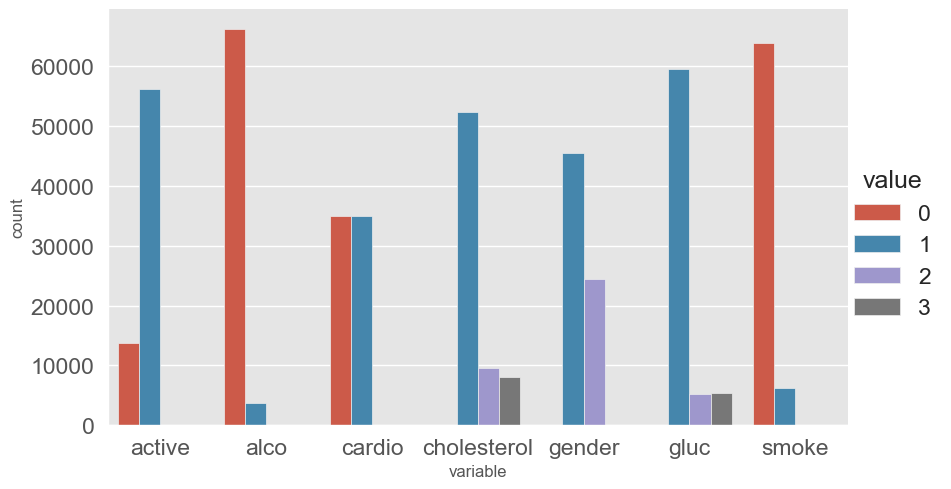

In [4]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active', 'cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 
                                              'value'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.catplot(x='variable', y='count', hue='value',
            data=df_uniques, kind='bar', aspect=1.75)

Ми бачимо, що цільові класи збалансовані. Це чудово!

Далі розділимо набір даних за цільовими значеннями. Чи можете ви вже помітити найважливішу ознаку, просто глянувши на графік?

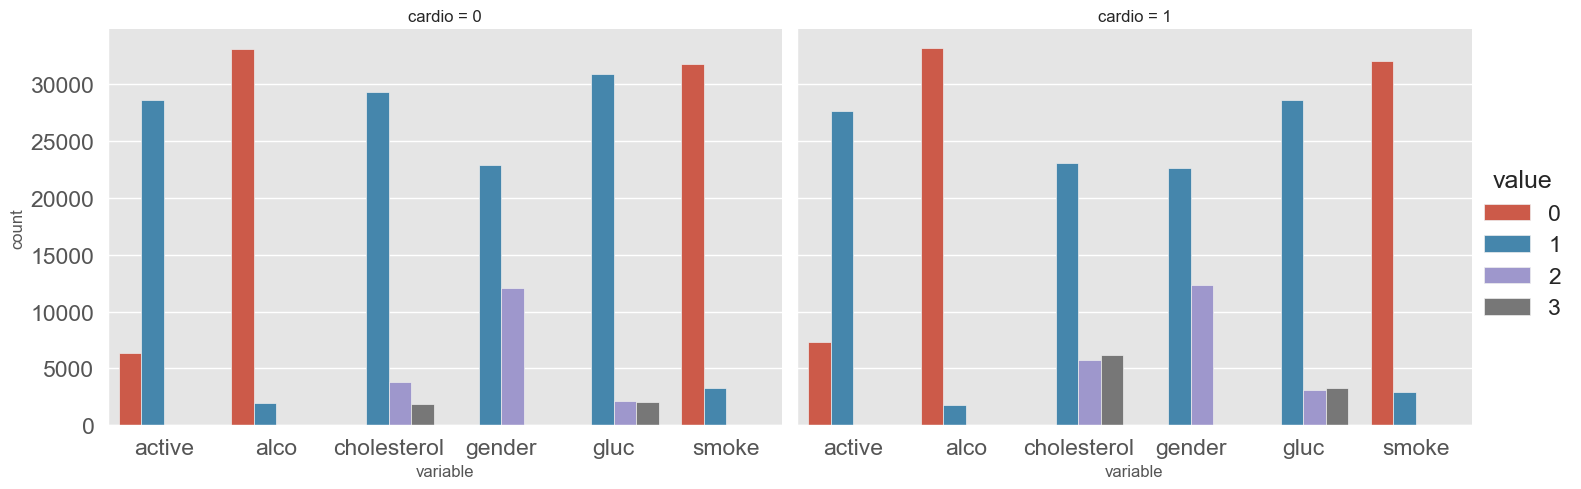

In [5]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active'], 
                     id_vars=['cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 'value', 
                                              'cardio'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.catplot(x='variable', y='count', hue='value', 
               col='cardio', data=df_uniques, kind='bar', aspect=1.5)

Бачимо, що розподіл рівнів холестерину та глюкози сильно відрізняється за значенням цільової змінної. Це випадковість?

Тепер обчислимо деякі статистичні показники для унікальних значень ознак:

In [6]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


У підсумку, маємо:
- 5 числових ознак (за винятком *id*);
- 7 категоріальних ознак;
- Всього 70000 записів.

## 1.1. Основні спостереження

### <span style="color:red; font-size:1.5em;">Завдання 1</span>

**Для варіантів 1-5:**

Скільки чоловіків і жінок присутні в цьому наборі даних? Значення ознаки *стать* не надано – з’ясуйте це, проаналізувавши зріст, зробивши припущення, що чоловіки в середньому вищі.

**Для варіантів 6-10:**

Яка стать частіше повідомляє про вживання алкоголю - чоловіки чи жінки?

**Для варіантів 11-15:**

Яка різниця між відсотками курців серед чоловіків і жінок (округлено)?

**Для варіантів 16-20:**

Яка різниця між медіанними значеннями віку для курців і некурців (у місяцях, округлено)? Вам потрібно буде визначити одиниці ознаки "вік" у цьому наборі даних.

## 1.2. Мапи ризиків

На вебсайті Європейського товариства кардіологів надається [шкала SCORE](https://www.escardio.org/Education/Practice-Tools/CVD-prevention-toolbox/SCORE-Risk-Charts). Вона використовується для розрахунку ризику смерті від серцево-судинного захворювання в найближчі 10 років. Ось вона:

<img src=https://habrastorage.org/webt/ik/gx/hr/ikgxhr3w1vzqihgitgrbdorfb14.png width=30%>

Глянемо на верхній правий прямокутник, який показує підгрупу курців у віці від 60 до 65 років. (Це неочевидно, але значення на мапі відображають верхню межу).

Ми бачимо значення 9 у нижньому лівому куті прямокутника та 47 у верхньому правому. Це означає, що для людей цієї статево-вікової групи, у яких систолічний тиск менше 120, ризик серцево-судинних захворювань оцінюється в 5 разів нижче, ніж для тих, хто має тиск в інтервалі [160, 180).

Далі обчислимо цей коефіцієнт, використовуючи наші дані.

Уточнення:
- Розрахувати ознаку ``age_years`` – округлити вік до найближчої кількості років. Для цього завдання відбирайте лише людей віком від 60 до 64 років включно.
- Категорії рівня холестерину відрізняються між цифрою та нашим набором даних. Перерахунок для ознаки ``cholesterol`` наступний: 4 mmol/l $\rightarrow$ 1, 5-7 mmol/l $\rightarrow$ 2, 8 mmol/l $\rightarrow$ 3.

### <span style="color:red; font-size:1.5em;">Завдання 2</span>

**Для варіантів 1-5:**

Обчисліть частку людей із ССЗ для двох описаних вище сегментів. Яке відношення цих двох дробів?

**Для варіантів 6-10:**

Обчисліть частку людей із ССЗ для двох описаних вище сегментів. Яке відношення цих двох дробів?

**Для варіантів 11-15:**

Обчисліть частку людей із ССЗ для двох описаних вище сегментів. Яке відношення цих двох дробів?

**Для варіантів 16-20:**

Обчисліть частку людей із ССЗ для двох описаних вище сегментів. Яке відношення цих двох дробів?

## 1.3. Аналіз ІМТ

### <span style="color:red; font-size:1.5em;">Завдання 3</span>

**Для всіх варіантів:**

Створіть нову ознаку – ІМТ ([Індекс маси тіла](https://www.wikiwand.com/uk/%D0%86%D0%BD%D0%B4%D0%B5%D0%BA%D1%81_%D0%BC%D0%B0%D1%81%D0%B8_%D1%82%D1%96%D0%BB%D0%B0)). Для цього розділіть вагу в кілограмах на квадрат зростання в метрах. Нормальними значеннями ІМТ вважаються від 18,5 до 25.

**Для варіантів 1-5:**

Чи дійсно медіана для показника ІМТ у зразку перебуває в межах нормальних значень ІМТ? Відповідь обґрунтуйте за обчисленим значенням ІМТ.

**Для варіантів 6-10:**

Чи дійсно значення ІМТ для жінок в середньому вище, ніж для чоловіків? Відповідь обґрунтуйте за обчисленим значенням ІМТ.

**Для варіантів 11-15:**

Чи справді здорові люди мають у середньому вищий ІМТ, ніж люди з ССЗ? Відповідь обґрунтуйте за обчисленим значенням ІМТ.

**Для варіантів 16-20:**

Чи правда, що у здорових чоловіків, які не вживають алкоголю, значення ІМТ ближче до норми, ніж у здорових жінок, які не п'ють? Відповідь обґрунтуйте за обчисленим значенням ІМТ.

## 1.4. Очищення даних

Варто пам'ятати, дані не є ідеальними. Набір містить зайву інформацію та неточності. Візуалізуємо дані, щоби побачити це наочно.

### <span style="color:red; font-size:1.5em;">Завдання 4</span>

Відфільтруйте (приберіть) наступні сегменти пацієнтів (ми вважаємо їх помилковими даними)

**Для варіантів 1-5:**

Діастолічний тиск вище систолічного. Скільки відсотків початкових даних (округлених) було відкинуто?

**Для варіантів 6-10:**

Зріст строго більше 97,5 процентиля. Скільки відсотків початкових даних (округлених) було відкинуто?

**Для варіантів 11-15:**

Вага строго менше 2,5 процентиля. Скільки відсотків початкових даних (округлених) було відкинуто?

**Для варіантів 16-20:**

Вага строго більше 97,5 процентиля. Скільки відсотків початкових даних (округлених) було відкинуто?


# Частина 2. Візуальний аналіз даних. Візуалізація кореляційної матриці

Щоб краще зрозуміти ознаки, створимо матрицю коефіцієнтів кореляції між ознаками. Використовуйте відфільтрований набір даних.


### <span style="color:red; font-size:1.5em;">Завдання 5</span>

**Для варіантів 1-5:**

Побудуйте кореляційну матрицю за допомогою [`heatmap()`](http://seaborn.pydata.org/generated/seaborn.heatmap.html). Ви можете створити матрицю за допомогою стандартних інструментів `pandas` із параметрами за замовчуванням.

***Яка пара ознак має найсильнішу кореляцію Пірсона з ознакою `cardio`?***

**Для варіантів 6-10:**

З нашого дослідження унікальних значень раніше ми знаємо, що стать кодується значеннями *1* і *2*. Хоча ви не знаєте відображення цих значень і статі, ви можете з’ясувати це графічно, подивившись на середні значення зросту та ваги для кожного значення ознаки `gender`.

Створіть `count plot` за допомогою [`countplot()`](http://seaborn.pydata.org/generated/seaborn.countplot.html) із віком на осі *X* і кількістю людей на осі *Y*. Ваш вихідний графік повинен мати два стовпці для кожного віку, що відповідає кількості людей для кожного *кардіо* класу цього віку.

***Який найменший вік, у якому кількість людей із ССЗ перевищує кількість людей без ССЗ?***

**Для варіантів 11-15:**

[Рангова кореляція](https://en.wikipedia.org/wiki/Rank_correlation) може допомогти ідентифікувати такі пари ознак, у яких нижчий ранг у варіаційному ряду однієї ознаки завжди передує вищому рангу в іншій (і маємо протилежне у випадку від’ємної кореляції).

Обчисліть і побудуйте кореляційну матрицю, використовуючи [коефіцієнт рангової кореляції Спірмена](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).

***Яка пара ознак має найсильнішу рангову кореляцію? Поясніть причину, чому саме між цими двома ознаками рангова кореляція виявилась найсильнішою.***

**Для варіантів 16-20:**

Створіть `violin plot` для `gender` та `height` за допомогою [`violinplot()`](https://seaborn.pydata.org/generated/seaborn.violinplot.html). Використовуйте параметри:
- `hue` для поділу за статтю;
- `scale` для оцінки кількості записів для кожної статі.

***Яка пара ознак має найсильнішу кореляцію Спірмена? Поясніть причину, чому саме між цими двома ознаками рангова кореляція виявилась найсильнішою.***

**Примітка:** щоб графік відтворювався правильно, вам потрібно перетворити ваш `DataFrame` у формат *long* за допомогою функції `melt()` з `pandas`. Ось [приклад](https://stackoverflow.com/a/41575149/3338479) цього для довідки.